# CoDaS-HEP Columnar Data Analysis, Part 1

This is the first of four notebooks on [columnar data analysis](https://indico.cern.ch/event/1287965/timetable/#41-columnar-data-analysis), presented at CoDaS-HEP at 13:30pm on July 20, 2023 by Jim Pivarski and Ioana Ifrim.

See the [GitHub repo](https://github.com/ioanaif/columnar-data-analysis-codas-hep-2023) for instructions on how to run it.

<br><br><br><br><br>

## Programming paradigms

Programming languages are for humans, not computers.

<br><br>

They bridge the gap between patterns of flowing electrons and the way humans conceptualize logical necessity (i.e. math).

<br><br>

Humans don't all think the same way about math, and one person doesn't always think about it the same way in different problems. That's why we need different **programming languages**.

<br><br>

But there are only a few ways that programming languages can be fundamentally different from each other, and even these have overlaps. They're called **programming paradigms**.

<br><br>

You might have heard of a few, or at least recognize them when you see them.

<br><br><br><br><br>

### Sample problem

Let's illustrate a few programming paradigms in the context of a single problem.

Suppose that we have a 1D array `A` and a 2D array `B`, and we want to

   * multiply `A[i]` and `B[i, j]` for each horizontal index `i`,
   * sum over those products along vertical index `j`,
   * resulting in a 1D array, indexed only by `i`.

<img src="../img/paradigms-problem.png" width="500">

In [1]:
import numpy as np

In [2]:
A = np.array([10, 20, 30])

B = np.array([[ 1,  2,  3,  4],
              [ 5,  6,  7,  8],
              [ 9, 10, 11, 12]])

We want to get an output that is

In [3]:
np.array([
    A[0]*B[0, 0] + A[0]*B[0, 1] + A[0]*B[0, 2] + A[0]*B[0, 3],
    A[1]*B[1, 0] + A[1]*B[1, 1] + A[1]*B[1, 2] + A[1]*B[1, 3],
    A[2]*B[2, 0] + A[2]*B[2, 1] + A[2]*B[2, 2] + A[2]*B[2, 3],
])

array([ 100,  520, 1260])

<br><br><br><br><br>

### Imperative

The imperative paradigm is probably the most familiar: you tell the computer exactly what to do for each element, step by step.

In [4]:
output = np.zeros(len(A), dtype=int)

for i in range(len(A)):
    ai = A[i]
    bi = B[i]
    for bij in bi:
        output[i] += ai * bij

output

array([ 100,  520, 1260])

If this had been written in another language, like C++, it would have the same structure, but different syntax.

```c++
auto output = std::vector<int>(A.size(), 0);

for (int i = 0; i < A.size(); i++) {
    auto ai = A[i];
    auto bi = B[i];
    for (int bij : bi) {
        output[i] += ai * bij;
    }
}
```

Imperative programs involve explicit instructions, loop blocks, and if/then/else blocks (indented in Python and in curly brackets in C).

For most of us today, this is just "normal programming," but it wasn't a part of the first programming languages. It was introduced by ALGOL (1958) and only became mainstream after it was [proven capable of universal computation](https://en.wikipedia.org/wiki/Structured_program_theorem) (1966), such that programming languages [wouldn't need a GOTO statement anymore](https://doi.org/10.1145%2F362929.362947) (1968). Most physicists have been using this style [since Fortran 77](https://en.wikipedia.org/wiki/Fortran#FORTRAN_77) (1977), and some [a little earlier](https://onlinelibrary.wiley.com/doi/10.1002/spe.4380050408) (1975).

The downsides of imperative programming are:

   * it can be _too_ prescriptive, preventing compilers from finding faster algorithms than the one you wrote,
   * some languages, like Python, have considerable overhead for each statement.

Imperative programming in Python is slow.

<br><br><br><br><br>

### Functional

The functional paradigm replaces blocks of code—that which is indented in Python and between curly brackets in C—with functions.

Instead of `if` and loop syntax like `for` and `while`, functional languages have "functors" that take functions as arguments, and the functors do the work.

Most functional programming languages use the same names for these common functors: `map`, `reduce`, `filter`, `scan`, `fold`, `flatten`, `flatmap`, ... ([in Python](https://web.mit.edu/6.005/www/fa15/classes/25-map-filter-reduce/), [in LISP](https://www.cs.cmu.edu/Groups/AI/html/cltl/clm/node143.html), [in Java](https://belief-driven-design.com/functional-programm-with-java-map-filter-reduce-77e479bd73e/), [in Swift](https://abhimuralidharan.medium.com/higher-order-functions-in-swift-filter-map-reduce-flatmap-1837646a63e8)...)

If you're familiar with [ROOT's RDataFrame](https://root.cern/doc/master/classROOT_1_1RDataFrame.html), this is a great example of functional programming in physics.

Here is a functional solution to the sample problem:

In [5]:
def fun(args):
    i, (ai, bi) = args
    return sum(map(lambda bij: ai * bij, bi))

np.fromiter(map(fun, enumerate(zip(A, B))), dtype=int)

array([ 100,  520, 1260])

In the above,

   * `lambda` makes an inline user-defined function and `def` makes one capable of multiple statements,
   * `zip` makes a sequence by pairing elements of `A` with elements of `B`,
   * `enumerate` pairs indexes with the sequence,
   * `map` applies a function to every element of a sequence: `x[i] → f(x[i])`,
   * `sum` is a reducer that applies the function "`+`" to every pair of neighbors in the sequence, turning the sequence into a scalar.

In Python, list comprehensions are more common than explicit functions and `map` because the syntax is more streamlined. The above could be written as:

In [6]:
np.array([sum(ai * bij for bij in bi) for i, (ai, bi) in enumerate(zip(A, B))])

array([ 100,  520, 1260])

The advantage of functional programming is that these functional primitives—`map`, `reduce`, `filter`, etc.—can be parallelized, as long as the user-supplied function can be called on different arguments in any order. This can be guaranteed with [pure functions](https://en.wikipedia.org/wiki/Pure_function), which do not modify any variables outside of themselves.

[Google MapReduce](https://research.google/pubs/pub62/)/Hadoop started the "Big Data" sensation by implementing `map+filter` and `reduce` on distributed datasets (2004). Today, it's how distributed computing in Apache Spark works, as well as RDataFrame in ROOT.

The disadvantage _in Python_ is that the functional primitives are implemented imperatively, so it is still slow.

<br><br><br><br><br>

### Object-oriented

Object-oriented programming is another big one.

It has more to do with organizing the large-scale structure of a program into units, so while it can be applied to a small problem like this one, it doesn't help much.

In [7]:
class ABProductSum:
    def __init__(self):
        self._value = 0

    def accumulate(self, ai, bij):
        self._value += int(ai * bij)

    def __int__(self):
        return self._value

output = [ABProductSum(), ABProductSum(), ABProductSum()]

for i, (ai, bi) in enumerate(zip(A, B)):
    for bij in bi:
        output[i].accumulate(ai, bij)

np.array(output, dtype=int)

array([ 100,  520, 1260])

Above, each `ABProductSum` is only responsible for its own sum. It changes values in place, but in a localized way.

Object-oriented programming is often contrasted with functional programming because objects are often designed around modifying their own state and pure functions avoid any mutable state.

However, they're not incompatible: objects don't _need_ to have mutable state, and in some languages, class definitions are the only way to pass functions as arguments.

After all, a function is just an object with one important method ("call me").

In [8]:
class Map:
    def call_me(self, function, sequence):
        out = []
        for x in sequence:
            out.append(function.call_me(x))   # expects the function object to have an 'apply' method
        return out

class Sum:
    def call_me(self, sequence):
        out = 0
        for x in sequence:
            out += x
        return out

class UserFun1:
    def __init__(self, ai):   # UserFun1 knows about 'ai'; in functional programming, this is called a closure
        self._ai = ai

    def call_me(self, bij):     # the actual function only depends on 'bij'
        return self._ai * bij

class UserFun2:
    def call_me(self, args):
        i, (ai, bi) = args
        return Sum().call_me(Map().call_me(UserFun1(ai), bi))

np.fromiter(Map().call_me(UserFun2(), enumerate(zip(A, B))), dtype=int)

array([ 100,  520, 1260])

The advantage of object-oriented programming is that it is verbose: naming things and limiting scope within names helps large-scale programming.

The disadvantage of object-oriented programming is that it is verbose: this scaffolding is not always needed and can get in the way of solving small problems.

Also, it's implemented imperatively in Python, so no speed-up there.

<br><br><br><br><br>

### Array-oriented

Array-oriented (or "columnar") programming consists of operations on arrays. Most statements do something to a whole array.

Here's an array-oriented solution to the sample problem in one line:

In [9]:
np.sum(A[:, np.newaxis] * B, axis=1)

array([ 100,  520, 1260])

Did you catch that? Array-oriented programming is usually concise, which is only good when you know what's going on.

Breaking down the above,

In [10]:
A

array([10, 20, 30])

In [11]:
B

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

**Step 1:** NumPy has a rich slicing syntax. "`:`" means "pass a dimension through unchanged" and "`np.newaxis`" means "make a length-1 dimension here, at this depth of the slice."

In [12]:
A[:, np.newaxis]

array([[10],
       [20],
       [30]])

**Step 2:** Binary operations, such as "`*`", _broadcast_ arrays of different shapes.

Each row of `A[:, np.newaxis]` has 1 element; each row of `B` has 4, that 1 element is paired with _each_ of the 4 elements, to get 4 products per row.

In [13]:
A[:, np.newaxis] * B

array([[ 10,  20,  30,  40],
       [100, 120, 140, 160],
       [270, 300, 330, 360]])

**Step 3:** Reducers, such as `np.sum`, apply at a given `axis` (dimension).

We want to sum over the inner lists, not the outer lists, so that's `axis=1`, not `axis=0`.

In [14]:
np.sum(A[:, np.newaxis] * B, axis=1)

array([ 100,  520, 1260])

More on array-oriented programming later (the rest of this whole tutorial), but

   * the advantages are that it's concise (short expression) and explicit (you say exactly what happens to each array),
   * the disadvantages are that it's concise (hard to understand?) and explicit (interpreter can't optimize intermediate steps).

Array-oriented programming is how most scientific Python libraries manage to be _expressive_ and _fast_ (because loops over arrays are implemented in compiled code).

<br><br><br><br><br>

### Declarative

Usually, physicists use the word "declarative programming" to mean functional programming or array-oriented programming.

However, here is a solution to the sample problem in a truly declarative language:

In [15]:
np.einsum("i,ij -> i", A, B)

array([ 100,  520, 1260])

[NumPy's einsum language](https://ajcr.net/Basic-guide-to-einsum/) (the code between the quotation marks, above) can only multiply values from `A` with values from `B`, sum over axes, and transpose axes, but it does so in a way that it:

   * never says what order they should be performed in (as imperative programming would)
   * does not take arbitrary functions as arguments (as functional programming would)
   * doesn't describe any intermediate arrays (as array-oriented programming would)

It just associates letters on the left of `->` with axes of the input arrays, letters on the right of `->` with axes of the output array, repeated letters with same-axis, and omitted letters (in the output) with summed-over axes.

#### Minor aside: the name "einsum"

The language in `np.einsum` is more general than [the notation Einstein invented](https://en.wikipedia.org/wiki/Einstein_notation), and our sample problem needs that generality.

However, without the `->`,

In [16]:
np.einsum("i,ij", A, B)

array([380, 440, 500, 560])

is the same as $A_i \, B^i_j$, as Einstein would write it.

That solves a different problem, though: one in which the sum is over `axis=0`, rather than `axis=1`:

In [17]:
np.sum(A[:, np.newaxis] * B, axis=0)

array([380, 440, 500, 560])

#### Other declarative languages

The most common declarative language you're likely to encounter is regex, which does one thing: find substrings.

In [18]:
import re

In [19]:
for match in re.finditer(r"[aeiou]\b", "Where do we see a vowel at the end of a word?"):
    print(match)

<re.Match object; span=(4, 5), match='e'>
<re.Match object; span=(7, 8), match='o'>
<re.Match object; span=(10, 11), match='e'>
<re.Match object; span=(14, 15), match='e'>
<re.Match object; span=(16, 17), match='a'>
<re.Match object; span=(29, 30), match='e'>
<re.Match object; span=(38, 39), match='a'>


Others include configuration files in YAML, templates in C++, original SQL, etc.

Declarative languages are usually _mini-languages_.

The advantages are that they can be very suited to their task—concise and easy to read—and that they can be implemented in a highly optimized way.

The disadvantage is that they rarely generalize, and when they do, they lose their declarativeness (as modern SQL has).

<br><br><br><br><br>

As with all programming paradigms, there isn't a sharply defined rule to cleanly separate them, and a single codebase can use several paradigms.

They are _styles_, and they're useful because they each bring different programming concepts into the foreground:

| Paradigm | Emphasizes |
|:-:|:-:|
| imperative/procedural | low-level algorithms |
| object-oriented | large-scale program structure |
| actor-based | temporal locality |
| literate | human instruction |
| event-driven | cause-and-effect |
| declarative | properties of desired result |
| symbolic | formula transformations |
| functional | data transformations |
| array-oriented | data distributions |

History of programming paradigms mentioned at CHEP (Computing in HEP conferences since 1985).

<img src="../img/chep-papers-paradigm.svg" width="700">

<br><br><br><br><br>

## Array-oriented programming

### History

Just as imperative programming comes from ALGOL (and functional from LISP, and object-oriented from Simula, ...), array-oriented programming comes from APL.

<img src="../img/apl-timeline.svg" width="700">

<img src="../img/apl-book.png" width="300" style="display: inline-block; margin-right: 20px">
<img src="../img/apl-keyboard.jpg" width="600" style="display: inline-block; margin-right: 20px">
<img src="../img/tshirt.jpg" width="250" style="display: inline-block; margin-right: 20px">
<div style="display: inline-block">

| APL | <br> | Numpy |
|:---:|:----:|:-----:|
| <tt>ι4</tt> | <br> | <tt>np.arange(1, 5)</tt> |
| <tt>(3+ι4)</tt> | <br> | <tt>np.arange(1, 5) + 3</tt> |
| <tt>+/(3+ι4)</tt> | <br> | <tt>(np.arange(1, 5) + 3).sum()</tt> |
| <tt>m ← +/(3+ι4)</tt> | <br> | <tt>m = (np.arange(1, 5) + 3).sum()</tt> |

</div>

<br><br><br><br><br>

Incidentally, a [solution to the sample problem in APL](https://tio.run/##SyzI0U2pTMzJT///31HhUdsEBUMDhcPTFR71blYw5nICixgrmAD5W8BihkZcXI/6poKEtfUVNDSA4k6aYFkIM9ooVkFfwVETZIbT//8A) is

```apl
A ← 10 × ⍳ 3
B ← 3 4 ⍴ ⍳ 12

+/ ((⍴B) ⍴ (⍴B)[2] / A) × B
```

<br><br><br><br><br>

### Synergy with data analysis

A common feature among all array-oriented languages (except Fortran 90) is that they are also _interactive_ languages.

<br><br>

Typically, you perform one operation on a whole dataset, see what that does to the distribution, then apply another.

<br><br>

In these applications, it would not be sufficient to see what they do to a few values. The _distributions_ are what matters. In imperative style, you'd have to write a whole loop before plotting each step.

In [20]:
import matplotlib.pyplot as plt

In [21]:
dataset = np.random.normal(0, 1, 1000000)  # one MILLION data points

<br><br>

"What does this distribution look like?"

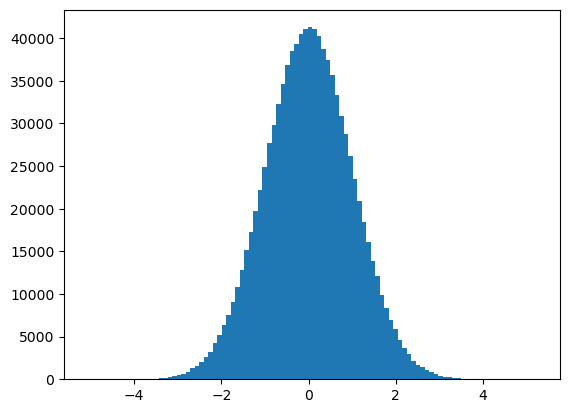

In [22]:
plt.hist(dataset, bins=100);

"Of course. It's Gaussian."

<br><br>

"What does the square look like?"

In [23]:
dataset2 = dataset**2

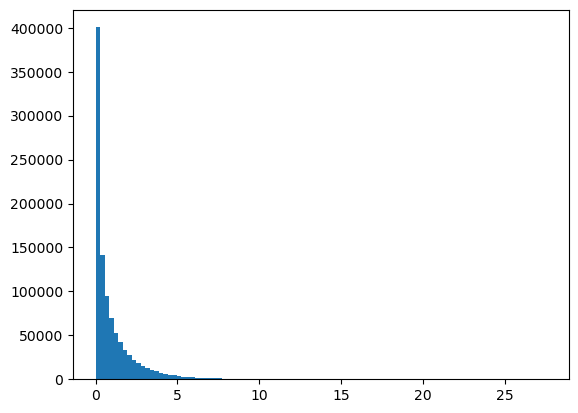

In [24]:
plt.hist(dataset2, bins=100);

"Of course. It's always positive, peaks at 0, and falls off to 25, rather than 5."

<br><br>

"What does this crazy combination look like?"

In [25]:
dataset3 = np.sin(1/dataset2)

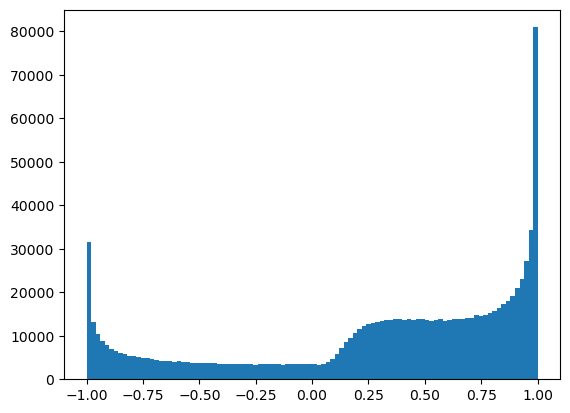

In [26]:
plt.hist(dataset3, bins=100);

"Um... That was hard to guess. It's not surprising that it's bounded between -1 and 1, but you wouldd have to think hard about why it favors positive values."

<br><br><br><br><br>

This is the way of interactive programming on data—which is to say, data analysis.

   * Acting on an array in each statement is the right level of granularity because you're interested in distributions.
   * The right part of the calculation is optimized by precompiled routines: the loop over all data.

It's not _just_ about computation speed. If you're not developing interactively (IPython/Jupyter or terminal), you're losing half the advantage.

<br><br><br><br><br>

### Accelerating code in Python

While we emphasize speed in Python array-oriented programming, it's not the fastest thing around.

Generally:

$$\mbox{Python ``for'' loops} \hspace{1 cm} \ll \hspace{1 cm} \mbox{NumPy expression} \hspace{1 cm} \ll \hspace{1 cm} \mbox{single-pass compiled loop} \hspace{1 cm} \ll \hspace{1 cm} \mbox{carefully tuned code}$$

<br><br><br><br><br>

Consider this function, which can be applied to Python scalars or NumPy arrays (works as imperative or array-oriented).

In [27]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

In [28]:
a = 5
b = 10
c = -0.1

quadratic_formula(a, b, c)

0.009950493836207741

In [29]:
a = np.random.uniform(5, 10, 500000)
b = np.random.uniform(10, 20, 500000)
c = np.random.uniform(-0.1, 0.1, 500000)

quadratic_formula(a, b, c)

array([-0.00138943,  0.00258499,  0.00382633, ...,  0.00358178,
        0.00308975, -0.00187663])

<br><br><br><br><br>

The NumPy execution is _approximately_ equivalent to the following:

In [30]:
def quadratic_formula_2(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8

In [31]:
quadratic_formula(a, b, c)

array([-0.00138943,  0.00258499,  0.00382633, ...,  0.00358178,
        0.00308975, -0.00187663])

Each step in the calculation makes an intermediate array (`tmp1` through `tmp8`), which requires memory allocation and copying, most of them CPU cache-misses.

("_Approximately_" because NumPy now has the ability to "fuse" some steps in a calculation, but not all.)

<br><br><br><br><br>

Compare:

In [32]:
%%timeit -o

quadratic_formula(a, b, c)

1.19 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 1.19 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [33]:
quadratic_numpy1 = _

In [34]:
%%timeit -o

quadratic_formula_2(a, b, c)

1.43 ms ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 1.43 ms ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [35]:
quadratic_numpy2 = _

<br><br><br><br><br>

Meanwhile, NumExpr compiles an expression for use in a fast (single-purpose) virtual machine that makes only one pass over the data.

In [36]:
import numexpr

numexpr.evaluate("(-b + sqrt(b**2 - 4*a*c)) / (2*a)")

array([-0.00138943,  0.00258499,  0.00382633, ...,  0.00358178,
        0.00308975, -0.00187663])

In [37]:
%%timeit -o

numexpr.re_evaluate()

487 µs ± 7.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 487 µs ± 7.04 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [38]:
quadratic_numexpr = _

<br><br><br><br><br>

There are also frameworks like Numba, which compile a subset of Python to machine code with LLVM.

To use Numba effectively, you must write imperative code.

In [39]:
import numba as nb

numba_quadratic_formula = nb.vectorize(quadratic_formula)

numba_quadratic_formula(a, b, c)

array([-0.00138943,  0.00258499,  0.00382633, ...,  0.00358178,
        0.00308975, -0.00187663])

In [40]:
%%timeit -o

numba_quadratic_formula(a, b, c)

532 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 532 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [41]:
quadratic_numba = _

<br><br><br><br><br>

JAX is another compiler of a subset of Python, but it takes a different approach with XLA.

To use JAX at all, you must write array-oriented code.

In [42]:
import jax

def quadratic_formula_3(a, b, c):
    return (-b + jax.numpy.sqrt(b**2 - 4*a*c)) / (2*a)

jax_quadratic_formula = jax.jit(quadratic_formula_3, backend="cpu")

jax_quadratic_formula(a, b, c)

Array([-0.00138941,  0.00258496,  0.00382628, ...,  0.00358181,
        0.00308982, -0.00187663], dtype=float32)

In [43]:
%%timeit -o

jax_quadratic_formula(a, b, c)

705 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 705 µs ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [44]:
quadratic_jax = _

<br><br><br><br><br>

Finally, we'd also like a comparison with imperative Python.

In [45]:
a_list = a.tolist()
b_list = b.tolist()
c_list = c.tolist()

In [46]:
%%timeit -o

for ai, bi, ci in zip(a_list, b_list, c_list):
    quadratic_formula(ai, bi, ci)

567 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 567 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [47]:
quadratic_python = _

<br><br><br><br><br>

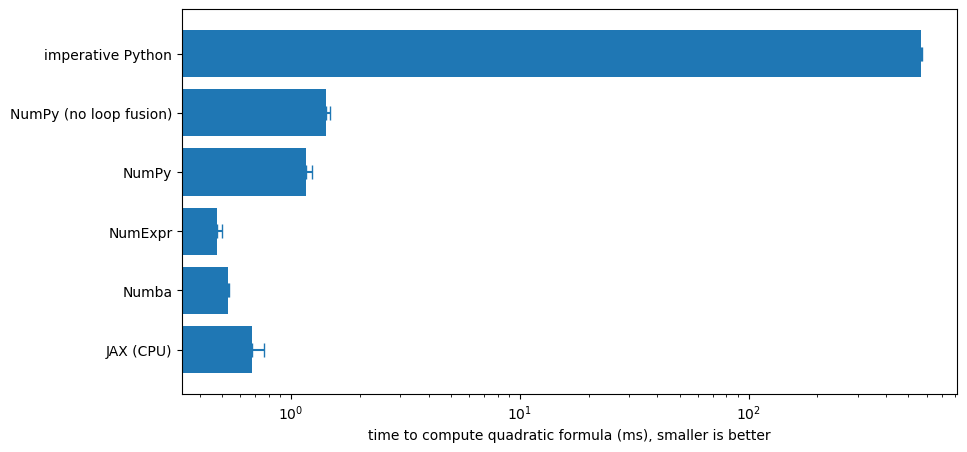

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

test_names = [
    "imperative Python",
    "NumPy (no loop fusion)",
    "NumPy",
    "NumExpr",
    "Numba",
    "JAX (CPU)",
][::-1]
test_results = np.array([
    1e3 * np.min(quadratic_python.all_runs) / quadratic_python.loops,
    1e3 * np.min(quadratic_numpy2.all_runs) / quadratic_numpy2.loops,
    1e3 * np.min(quadratic_numpy1.all_runs) / quadratic_numpy1.loops,
    1e3 * np.min(quadratic_numexpr.all_runs) / quadratic_numexpr.loops,
    1e3 * np.min(quadratic_numba.all_runs) / quadratic_numba.loops,
    1e3 * np.min(quadratic_jax.all_runs) / quadratic_jax.loops,
][::-1])
test_variations = np.array([
    1e3 * np.ptp(quadratic_python.all_runs) / quadratic_python.loops,
    1e3 * np.ptp(quadratic_numpy2.all_runs) / quadratic_numpy2.loops,
    1e3 * np.ptp(quadratic_numpy1.all_runs) / quadratic_numpy1.loops,
    1e3 * np.ptp(quadratic_numexpr.all_runs) / quadratic_numexpr.loops,
    1e3 * np.ptp(quadratic_numba.all_runs) / quadratic_numba.loops,
    1e3 * np.ptp(quadratic_jax.all_runs) / quadratic_jax.loops,
][::-1])
ax.barh(range(len(test_names)), test_results);
ax.errorbar(test_results + test_variations/2, range(len(test_names)), xerr=test_variations/2, capsize=5, fmt="none", c="#1f77b4");
ax.set_yticks(range(len(test_names)));
ax.set_yticklabels(test_names);
ax.set_xlabel("time to compute quadratic formula (ms), smaller is better");
ax.set_xscale("log");
ax.set_ylim(-0.75, len(test_results) - 0.25);

<br><br><br><br><br>

Array-oriented programming in Python is usually about 100× better than imperative Python.

But there's still a factor-of-several, maybe even 10×, improvement to be made with a single-pass algorithm.

<br><br><br><br><br>

# Next stop: part 2

Go to [lecture-part-2.ipynb](lecture-part-2.ipynb) for the second notebook.